## Import the packages

In [0]:
import tensorflow as tf
import random
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from sklearn.model_selection import train_test_split
%matplotlib inline

EPS = 1e-12

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!ls "/content/drive/My Drive/Colab Notebooks"

 butterfly					   Models.ipynb
 dataset					   Models_new.ipynb
'Generative Adversarial Networks Tutorial.ipynb'   output
 input						   PyTorch.ipynb
 knn.ipynb					   Untitled.ipynb


## Load the dataset

In [0]:
def make_square(image):
    height, width = image.shape[0], image.shape[1]
    size = max(height, width)
    top = bottom = int((size - height) / 2)
    left = right = int((size - width) / 2)
    new_image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value = [0, 0, 0])
    return new_image

In [0]:
# cwd = os.chdir("/content/drive/My Drive/Colab Notebooks")
cwd = "/content/drive/My Drive/Colab Notebooks"
#path_input = cwd + "/dataset/input"
#path_output = cwd + "/dataset/output"
path_input = cwd + "/input"
path_output = cwd + "/output"

In [6]:
print(cwd)

/content/drive/My Drive/Colab Notebooks


In [7]:
# Original Dimensions for train
N = 832
image_width = 256
image_height = 256
channels = 3
ratio = 1

image_width = int(image_width / ratio)
image_height = int(image_height / ratio)
dimension = (image_width, image_height)

i = 0

X = np.ndarray(shape = (N, image_height, image_width), dtype = np.float32)
Y = np.ndarray(shape = (N, image_height, image_width, channels), dtype = np.float32)

for filename in sorted(os.listdir(path_input)):
    if filename.endswith(".png"):
        image_input = cv2.imread(path_input + "/" + filename, cv2.IMREAD_UNCHANGED)
        #image_input = make_square(image_input)
        #image_input = cv2.resize(image_input, dimension, interpolation = cv2.INTER_NEAREST)
        image_input = np.array(np.asarray(image_input))
        
        image_output = cv2.imread(path_output + "/" + filename, cv2.IMREAD_UNCHANGED)
        # image_output = make_square(image_output)
        #image_output = cv2.resize(image_output, dimension, interpolation = cv2.INTER_NEAREST)
        image_output = np.array(np.asarray(image_output))
        
        X[i] = image_input
        Y[i] = image_output
        i += 1
        
        if i % 100 == 0:
            print(str(i) + " images are done!")
    else:
        continue

100 images are done!
200 images are done!
300 images are done!
400 images are done!
500 images are done!
600 images are done!
700 images are done!
800 images are done!


In [0]:
X = np.reshape(X, [N, image_height, image_width, 1])

In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.25, random_state = 13)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.125, random_state = 13)
print("Train set size: {0}, Val set size: {1}, Test set size: {2}".format(len(X_train), len(X_val), len(X_test)))
print("X_train shape: {0}, X_val shape: {1}, X_test shape: {2}".format(X_train.shape, X_val.shape, X_test.shape))
print("Y_train shape: {0}, Y_val shape: {1}, Y_test shape: {2}".format(Y_train.shape, Y_val.shape, Y_test.shape))

Train set size: 546, Val set size: 78, Test set size: 208
X_train shape: (546, 256, 256, 1), X_val shape: (78, 256, 256, 1), X_test shape: (208, 256, 256, 1)
Y_train shape: (546, 256, 256, 3), Y_val shape: (78, 256, 256, 3), Y_test shape: (208, 256, 256, 3)


In [10]:
print(len(X_train.shape))

4


[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]


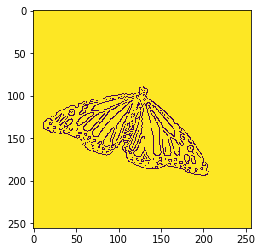

In [11]:
image = X[0].reshape([image_height, image_width])
print(image.astype('uint8'))
plt.imshow(image.astype('uint8'))
plt.show()

## The Discriminator Network

## The Generator Network

In [0]:
def discriminator(color_image, edge_image, reuse=False):
  with tf.variable_scope('discriminator') as scope:
    if(reuse):
      tf.get_variable_scope().reuse_variables()
    
    input_image = tf.concat([color_image, edge_image], axis=3)
    batch_size, height, width, channels = input_image.get_shape()
    
    height = int(height)
    width = int(width)
    channels = int(channels)
    hidden_sizes = [32, 64, 128, 256]
    kerne_size = 5
    # the First CONV Layer
    W_conv1 = tf.get_variable('d_wconv1', [kerne_size, kerne_size, channels, hidden_sizes[0]], initializer=tf.random_normal_initializer(0, 0.02))
    b_conv1 = tf.get_variable('d_bconv1', [hidden_sizes[0]], initializer=tf.constant_initializer(0))
    h_conv1 = tf.nn.conv2d(input=input_image, filter = W_conv1, strides=[1,1,1,1], padding='SAME') + b_conv1
    # h_conv1 = tf.contrib.layers.batch_norm(inputs = h_conv1, center=True, scale=True, is_training=True, scope="d_bn1")
    h_conv1 = tf.nn.relu(h_conv1)
    h_pool1 = tf.nn.max_pool(h_conv1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    # batch_size * 128 *128 * 64
    
    # the Second CONV Layer
    W_conv2 = tf.get_variable('d_wconv2', [kerne_size, kerne_size, hidden_sizes[0], hidden_sizes[1]], initializer=tf.random_normal_initializer(0, 0.02))
    b_conv2 = tf.get_variable('d_bconv2', [hidden_sizes[1]], initializer=tf.constant_initializer(0))
    h_conv2 = tf.nn.conv2d(input=h_pool1, filter = W_conv2, strides=[1,1,1,1], padding='SAME') + b_conv2
    #h_conv2 = tf.contrib.layers.batch_norm(inputs = h_conv2, center=True, scale=True, is_training=True, scope="d_bn1")
    h_conv2 = tf.nn.relu(h_conv2)
    h_pool2 = tf.nn.max_pool(h_conv2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    # batch_size * 64 *64 * 128
    
    # the Third CONV Layer
    W_conv3 = tf.get_variable('d_wconv3', [kerne_size, kerne_size, hidden_sizes[1], hidden_sizes[2]], initializer=tf.random_normal_initializer(0, 0.02))
    b_conv3 = tf.get_variable('d_bconv3', [hidden_sizes[2]], initializer=tf.constant_initializer(0)) 
    h_conv3 = tf.nn.conv2d(input=h_pool2, filter = W_conv3, strides=[1,1,1,1], padding='SAME') + b_conv3
    #h_conv3 = tf.contrib.layers.batch_norm(inputs = h_conv3, center=True, scale=True, is_training=True, scope="d_bn2")
    h_conv3 = tf.nn.relu(h_conv3)
    h_pool3 = tf.nn.max_pool(h_conv3, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    # batch_size * 32 *32 * 256
    
    # the Fourth CONV Layer
    W_conv4 = tf.get_variable('d_wconv4', [kerne_size, kerne_size, hidden_sizes[2], hidden_sizes[3]], initializer=tf.random_normal_initializer(0, 0.02))
    b_conv4 = tf.get_variable('d_bconv4', [hidden_sizes[3]], initializer=tf.constant_initializer(0)) 
    h_conv4 = tf.nn.conv2d(input=h_pool3, filter = W_conv4, strides=[1,1,1,1], padding='SAME') + b_conv4
    #h_conv4 = tf.contrib.layers.batch_norm(inputs = h_conv4, center=True, scale=True, is_training=True, scope="d_bn3")
    h_conv4 = tf.nn.relu(h_conv4)
    h_pool4 = tf.nn.max_pool(h_conv4, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    # batch_size * 16 * 16 * 512
    
    # convolved = tf.layers.conv2d(h_pool4, 1, kernel_size=4, strides=1, padding='SAME', kernel_initializer=tf.random_normal_initializer(0, 0.02))
    # y = tf.sigmoid(convolved)
    
    # After passing four conv layers, shape of the image become h/16 * w/16 * hiddensize3
    # The First Fully Connected Layer
    W_fc1 = tf.get_variable('d_wfc1', [int(height/16) * int(width/16) * hidden_sizes[3], 1000], initializer=tf.random_normal_initializer(0, 0.02))
    b_fc1 = tf.get_variable('d_bfc1', [1000], initializer=tf.constant_initializer(0))
    h_pool4_flat = tf.reshape(h_pool4, [-1, int(height/16) * int(width/16) * hidden_sizes[3]])
    h_fc1 = tf.nn.relu(tf.matmul(h_pool4_flat, W_fc1) + b_fc1)
      
    # The Second Fully Connected Layer
    W_fc2 = tf.get_variable('d_wfc2', [1000, 32], initializer=tf.random_normal_initializer(0, 0.02))
    b_fc2 = tf.get_variable('d_bfc2', [32], initializer=tf.constant_initializer(0))
    #h_fc1_flat = tf.reshape(h_fc1, [-1, 1000])
    h_fc2 = tf.nn.relu(tf.matmul(h_fc1, W_fc2) + b_fc2)
     
    # The First Fully Connected Layer
    W_fc3 = tf.get_variable('d_wfc3', [32, 1], initializer=tf.random_normal_initializer(0, 0.02))
    b_fc3 = tf.get_variable('d_bfc3', [1], initializer=tf.constant_initializer(0))
    #h_fc2_flat = tf.reshape(h_fc2, [-1, 32])
    y = tf.sigmoid(tf.matmul(h_fc2, W_fc3) + b_fc3)
    
  return y   
      

In [0]:
def generator(edge_image, batch_size, reuse=False):
  with tf.variable_scope('generator') as scope:
    if(reuse):
      tf.get_variable_scope().reuse_variables()

    # get the height, width and channels of the image
    batch_size, height, width, channels = edge_image.get_shape()
    batch_size = int(batch_size)
    height = int(height)
    width = int(width)
    channels = int(channels)
    kernel_size = 5
    stride = 2
    # edge_image_flat = tf.reshape(edge_image, [batch_size, height * width * channels])
  
    color_dim = 3
  
    # downsample the edge image 
    # First CONV Layer
    W_conv1 = tf.get_variable('g_wconv1', [kernel_size, kernel_size, channels, 8], initializer=tf.random_normal_initializer(0, 0.02))
    b_conv1 = tf.get_variable('g_bconv1', [8], initializer=tf.constant_initializer(0))
    # the stride is 1, the size remains the same
    h_conv1 = tf.nn.conv2d(input = edge_image, filter = W_conv1, strides=[1, stride, stride, 1], padding='SAME') + b_conv1
    h_conv1 = tf.nn.relu(h_conv1)
    h_conv1 = tf.layers.batch_normalization(inputs=h_conv1, axis=3, epsilon=1e-5, momentum=0.1, training=True, gamma_initializer=tf.random_normal_initializer(1.0, 0.02))
    # h_conv1 = tf.contrib.layers.batch_norm(inputs = h_conv1, center=True, scale=True, is_training=True, scope="g_bn1")
    # h_conv1 = tf.nn.relu(h_conv1)
    # h_pool1 = tf.nn.avg_pool(h_conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    # batch_size * 128 * 128 * 8
    
    # Second CONV Layer
    W_conv2 = tf.get_variable('g_wconv2', [kernel_size, kernel_size, 8, 16], initializer=tf.random_normal_initializer(0, 0.02))
    b_conv2 = tf.get_variable('g_bconv2', [16], initializer=tf.constant_initializer(0))
    h_conv2 = tf.nn.conv2d(input = h_conv1, filter = W_conv2, strides=[1, stride, stride, 1], padding='SAME') + b_conv2
    h_conv2 = tf.nn.relu(h_conv2)
    h_conv2 = tf.layers.batch_normalization(inputs=h_conv2, axis=3, epsilon=1e-5, momentum=0.1, training=True, gamma_initializer=tf.random_normal_initializer(1.0, 0.02))
    # h_conv2 = tf.nn.relu(h_conv2)
    # h_pool2 = tf.nn.avg_pool(h_conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    # batch_size * 64 * 64 * 16
    
    # Third CONV Layer
    W_conv3 = tf.get_variable('g_wconv3', [kernel_size, kernel_size, 16, 32], initializer=tf.random_normal_initializer(0, 0.02))
    b_conv3 = tf.get_variable('g_bconv3', [32], initializer=tf.constant_initializer(0))
    h_conv3 = tf.nn.conv2d(input = h_conv2, filter = W_conv3, strides=[1, stride, stride, 1], padding='SAME') + b_conv3
    h_conv3 = tf.nn.relu(h_conv3)
    h_conv3 = tf.layers.batch_normalization(inputs=h_conv3, axis=3, epsilon=1e-5, momentum=0.1, training=True, gamma_initializer=tf.random_normal_initializer(1.0, 0.02))
    #h_conv3 = tf.nn.relu(h_conv3)
    #h_pool3 = tf.nn.avg_pool(h_conv3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    # batch_size * 32 * 32 * 32
  
    # Fourth CONV Layer
    W_conv4 = tf.get_variable('g_wconv4', [kernel_size, kernel_size, 32, 32], initializer=tf.random_normal_initializer(0, 0.02))
    b_conv4 = tf.get_variable('g_bconv4', [32], initializer=tf.constant_initializer(0))
    h_conv4 = tf.nn.conv2d(input = h_conv3, filter = W_conv4, strides=[1, stride, stride, 1], padding='SAME') + b_conv4
    h_conv4 = tf.nn.relu(h_conv4)
    h_conv4 = tf.layers.batch_normalization(inputs=h_conv4, axis=3, epsilon=1e-5, momentum=0.1, training=True, gamma_initializer=tf.random_normal_initializer(1.0, 0.02))
    #h_conv4 = tf.nn.relu(h_conv4)
    #h_pool4 = tf.nn.avg_pool(h_conv4, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    # batch_size * 16 * 16 * 32
    
    # the size of h_pool4 is 16*16*128 now
  
    # batch_size, h4, w4, c4 = tf.shape(h_pool4)
    # The First Fully Connected Layer
    W_fc1 = tf.get_variable('g_wfc1', [(int(height/16)) * (int(width/16)) * 32, 1000], initializer=tf.random_normal_initializer(0, 0.02))
    b_fc1 = tf.get_variable('g_bfc1', [1000], initializer=tf.constant_initializer(0))
    h_conv4_flat = tf.reshape(h_conv4, [-1, (int(height/16)) * (int(width/16)) * 32])
    h_fc1 = tf.nn.relu(tf.matmul(h_conv4_flat, W_fc1) + b_fc1)
                                      
    # The Second Fully Connected Layer
    W_fc2 = tf.get_variable('g_wfc2', [1000, 64], initializer=tf.random_normal_initializer(0, 0.02))
    b_fc2 = tf.get_variable('g_bfc2', [64], initializer=tf.constant_initializer(0))
    h_fc2 = tf.nn.relu(tf.matmul(h_fc1, W_fc2) + b_fc2)
  
    # The input edge image is downsampled to an 100 vector
    # upsample the vector
    # change the 64 vector to 8*8 
    h0 = tf.reshape(h_fc2, [batch_size, 8, 8, 1])
    h0 = tf.nn.relu(h0)
  
    # the First DeCONV layer
    output_shape1 = [batch_size, (int(height/16)), (int(width/16)), 32]
    W_deconv1 = tf.get_variable('g_wdeconv1', [kernel_size, kernel_size, output_shape1[-1], int(h0.get_shape()[-1])], initializer=tf.random_normal_initializer(0, 0.02))
    b_deconv1 = tf.get_variable('g_bdeconv1', [output_shape1[-1]], initializer=tf.constant_initializer(0.1))
    h_deconv1 = tf.nn.conv2d_transpose(h0, W_deconv1, output_shape=output_shape1, strides=[1, 2, 2, 1], padding='SAME') + b_deconv1
    h_deconv1 = tf.contrib.layers.batch_norm(inputs = h_deconv1, center=True, scale=True, is_training=True, scope="g_bn1")
    h_deconv1 = tf.nn.relu(h_deconv1) + h_conv4
    # batch_size * 16 * 16 * 32
    
    # the Second DeCONV layer
    output_shape2 = [batch_size, (int(height/8)), (int(width/8)), 32]
    W_deconv2 = tf.get_variable('g_wdeconv2', [kernel_size, kernel_size, output_shape2[-1], int(h_deconv1.get_shape()[-1])], initializer=tf.random_normal_initializer(0, 0.02))
    b_deconv2 = tf.get_variable('g_bdeconv2', [output_shape2[-1]], initializer=tf.constant_initializer(0.1))
    h_deconv2 = tf.nn.conv2d_transpose(h_deconv1, W_deconv2, output_shape=output_shape2, strides=[1, 2, 2, 1], padding='SAME') + b_deconv2
    h_deconv2 = tf.contrib.layers.batch_norm(inputs = h_deconv2, center=True, scale=True, is_training=True, scope="g_bn2")
    h_deconv2 = tf.nn.relu(h_deconv2) + h_conv3                                  
    # batch_size * 32 * 32 * 32
    
    # the Third DeCONV layer
    output_shape3 = [batch_size, (int(height/4)), (int(width/4)), 16]
    W_deconv3 = tf.get_variable('g_wdeconv3', [kernel_size, kernel_size, output_shape3[-1], int(h_deconv2.get_shape()[-1])], initializer=tf.random_normal_initializer(0, 0.02))
    b_deconv3 = tf.get_variable('g_bdeconv3', [output_shape3[-1]], initializer=tf.constant_initializer(0.1))
    h_deconv3 = tf.nn.conv2d_transpose(h_deconv2, W_deconv3, output_shape=output_shape3, strides=[1, 2, 2, 1], padding='SAME') + b_deconv3
    h_deconv3 = tf.contrib.layers.batch_norm(inputs = h_deconv3, center=True, scale=True, is_training=True, scope="g_bn3")
    h_deconv3 = tf.nn.relu(h_deconv3) + h_conv2
    # batch_size * 64 * 64 * 16
    
    # the Final DeCONV layer
    output_shape4 = [batch_size, (int(height/2)), (int(width/2)), 8]
    W_deconv4 = tf.get_variable('g_wdeconv4', [kernel_size, kernel_size, output_shape4[-1], int(h_deconv3.get_shape()[-1])], initializer=tf.random_normal_initializer(0, 0.02))
    b_deconv4 = tf.get_variable('g_bdeconv4', [output_shape4[-1]], initializer=tf.constant_initializer(0.1))
    h_deconv4 = tf.nn.conv2d_transpose(h_deconv3, W_deconv4, output_shape=output_shape4, strides=[1, 2, 2, 1], padding='SAME') + b_deconv4
    h_deconv4 = tf.contrib.layers.batch_norm(inputs = h_deconv4, center=True, scale=True, is_training=True, scope="g_bn4")
    h_deconv4 = tf.nn.relu(h_deconv4) + h_conv1
    # batch_size * 128 * 128 * 8
    
    # The final DeCONV layer 
    output_shape5 = [batch_size, height, width, color_dim]
    W_deconv5 = tf.get_variable('g_wdeconv5', [kernel_size, kernel_size, output_shape5[-1], int(h_deconv4.get_shape()[-1])], initializer=tf.random_normal_initializer(0, 0.02))
    b_deconv5 = tf.get_variable('g_bdeconv5', [output_shape5[-1]], initializer=tf.constant_initializer(0.1))
    h_deconv5 = tf.nn.conv2d_transpose(h_deconv4, W_deconv5, output_shape=output_shape5, strides=[1, 2, 2, 1], padding='SAME') + b_deconv5
    h_deconv5 = tf.contrib.layers.batch_norm(inputs = h_deconv5, center=True, scale=True, is_training=True, scope="g_bn5")
    h_deconv5 = tf.nn.tanh(h_deconv5)
    # batch_size * 256 * 256 * 3
    
  return h_deconv5

## Get a sample image

In [0]:
height = 256
width = 256

In [0]:
sess = tf.Session()
edge_test_placeholder = tf.placeholder(tf.float32, [1, height, width, 1])

In [16]:
# sample image is generated by the generator with batch_size = 1
sample_image = generator(edge_test_placeholder, 1)
# a random image is used as the input edge image 
test_edge = np.random.uniform(0, 1, [1, height, width, 1])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.batch_normalization instead.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [0]:
sess.run(tf.global_variables_initializer())
temp = (sess.run(sample_image, feed_dict={edge_test_placeholder: test_edge}))


plot the output of an untrained generator

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


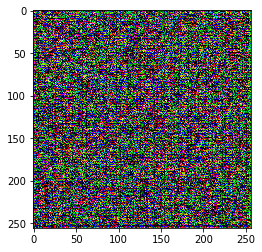

In [18]:
my_i = temp.squeeze()
# plt.imshow(my_i, cmap='gray_r')
plt.imshow(my_i)
plt.show()

## Train the GAN Network

In [0]:
batch_size = 6
tf.reset_default_graph() #Since we changed our batch size (from 1 to 16), we need to reset our Tensorflow graph

sess = tf.Session()
x_placeholder = tf.placeholder(tf.float32, [batch_size, height, width, 3]) #Placeholder for input images to the discriminator
z_placeholder = tf.placeholder(tf.float32, [batch_size, height, width, 1]) #Placeholder for input edge images to the generator

In [0]:
# discrimination result for the real images
Dx = discriminator(x_placeholder, z_placeholder)
# generate image from the edge image
Gz = generator(z_placeholder, batch_size)
# discrimination result for the generated images
Dg = discriminator(Gz, z_placeholder, reuse=True)

## The Loss function 

Loss function for the discriminator

In [0]:
#d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = Dx, labels = tf.ones_like(Dx)))
#d_loss_real = tf.losses.mean_squared_error(tf.ones_like(Dx), Dx)
#d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = Dg, labels = tf.zeros_like(Dg)))
#d_loss_fake = tf.losses.mean_squared_error(tf.zeros_like(Dg), Dg)
#d_loss = (d_loss_real + d_loss_fake) * 0.5

d_loss = tf.reduce_mean(-(tf.log(Dx + EPS) + tf.log(1 - Dg + EPS)))

Loss Function for the generator

In [0]:
#g_loss1 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = Dg, labels = tf.ones_like(Dg)))
#g_loss1 = tf.losses.mean_squared_error(tf.ones_like(Dg), Dg)
#g_loss2 = tf.losses.absolute_difference(x_placeholder, Gz)
#g_loss = g_loss1 + g_loss2
g_loss_GAN = tf.reduce_mean(-tf.log(Dg + EPS))
g_loss_L1 = tf.reduce_mean(tf.abs(x_placeholder - Gz))
g_loss = g_loss_GAN + g_loss_L1 * 10

the variables for the discriminator and the generator

In [0]:
tvars = tf.trainable_variables()
d_vars = [var for var in tvars if 'd_' in var.name]
g_vars = [var for var in tvars if 'g_' in var.name]

## The Optimizer

In [0]:
d_adam = tf.train.AdamOptimizer(learning_rate = 1e-5, beta1 = 0.5, beta2 = 0.999)
g_adam = tf.train.AdamOptimizer(learning_rate = 1e-5, beta1 = 0.9, beta2 = 0.999)
trainerD = d_adam.minimize(d_loss, var_list=d_vars)
trainerG = g_adam.minimize(g_loss, var_list=g_vars)

In [25]:
sess.run(tf.global_variables_initializer())

epoch = 20

for i in range(epoch):
  for j in range(int(546/batch_size)):
    #Update the discriminator
    _, dLoss = sess.run([trainerD, d_loss],feed_dict={z_placeholder: X_train[j * batch_size : (j+1) * batch_size], x_placeholder: Y_train[j * batch_size : (j+1) * batch_size]}) 
    
    #Update the generator
    _, gLoss = sess.run([trainerG, g_loss],feed_dict={z_placeholder: X_train[j * batch_size : (j+1) * batch_size], x_placeholder: Y_train[j * batch_size : (j+1) * batch_size]}) 
    if j == 0 :
        print("epoch: %s, iteration: %s, dLoss: %s, gLoss: %s " % (i, j, dLoss, gLoss))

epoch: 0, iteration: 0, dLoss: 1.3445166, gLoss: 2182.169 
epoch: 1, iteration: 0, dLoss: 0.0016129878, gLoss: 2187.4783 
epoch: 2, iteration: 0, dLoss: 0.00021532395, gLoss: 2189.1196 
epoch: 3, iteration: 0, dLoss: 7.367398e-05, gLoss: 2189.9888 
epoch: 4, iteration: 0, dLoss: 3.6458838e-05, gLoss: 2190.584 
epoch: 5, iteration: 0, dLoss: 2.1507583e-05, gLoss: 2191.0535 
epoch: 6, iteration: 0, dLoss: 1.3401205e-05, gLoss: 2191.4856 
epoch: 7, iteration: 0, dLoss: 8.1360695e-06, gLoss: 2191.9646 
epoch: 8, iteration: 0, dLoss: 5.662459e-06, gLoss: 2192.3142 
epoch: 9, iteration: 0, dLoss: 4.271676e-06, gLoss: 2192.5894 
epoch: 10, iteration: 0, dLoss: 3.1789202e-06, gLoss: 2192.853 
epoch: 11, iteration: 0, dLoss: 2.5928057e-06, gLoss: 2193.035 
epoch: 12, iteration: 0, dLoss: 2.0563627e-06, gLoss: 2193.2476 
epoch: 13, iteration: 0, dLoss: 1.5993928e-06, gLoss: 2193.4436 
epoch: 14, iteration: 0, dLoss: 1.3709081e-06, gLoss: 2193.6152 
epoch: 15, iteration: 0, dLoss: 1.1622914e-06, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


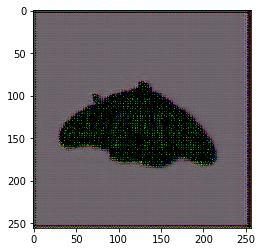

In [42]:
batch_size = 1
z_placeholder = tf.placeholder(tf.float32, [batch_size, height, height, 1])
sample_image = generator(z_placeholder, batch_size, reuse=True)
#z_batch = np.random.uniform(-1, 1, size=[1, z_dimensions])
z_batch = X[5]
z_batch = np.reshape(z_batch, [batch_size, height, width, 1])
#print(z_batch)
temp = (sess.run(sample_image, feed_dict={z_placeholder: z_batch}))
my_i = temp.squeeze()
plt.imshow(my_i)

In [27]:
real_batch = Y_train[0:5].reshape([5, 256, 256, 3])
edge_batch = X_train[0:5].reshape([5, 256, 256, 1])
real_result = discriminator(real_batch, edge_batch, reuse=True)
sess.run(real_result)

array([[1.       ],
       [1.       ],
       [1.       ],
       [0.9999999],
       [1.       ]], dtype=float32)

In [28]:
print(real_result)

Tensor("discriminator_2/Sigmoid:0", shape=(5, 1), dtype=float32)


In [29]:
z_placeholder = tf.placeholder(tf.float32, [5, height, height, 1])
# x_placeholder = tf.placeholder(tf.float32, [5, height, height, 3])
fake_batch = generator(z_placeholder, 5, reuse=True)
fake_result = discriminator(z_placeholder, fake_batch, reuse=True)
sess.run(fake_result, feed_dict={z_placeholder: edge_batch})

array([[0.99995077],
       [0.9999754 ],
       [0.99995756],
       [0.9999816 ],
       [0.9999821 ]], dtype=float32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


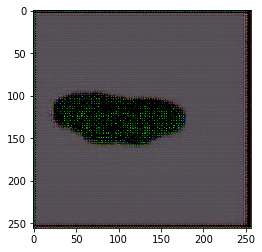

In [30]:
z_placeholder = tf.placeholder(tf.float32, [1, height, height, 1])
sample_image = generator(z_placeholder, batch_size, reuse=True)

z_batch = X_train[5]
z_batch = np.reshape(z_batch, [1, height, width, 1])
#print(z_batch)
temp = (sess.run(sample_image, feed_dict={z_placeholder: z_batch}))
my_i = temp.squeeze()
plt.imshow(my_i)

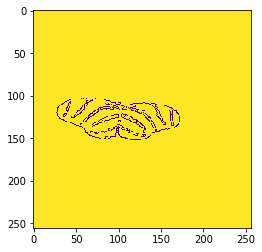

In [31]:
image = X_train[5].reshape([height, width])
plt.imshow(image)
plt.show()

In [0]:
#img = mpimg.imread(path_output + '/100007.jpg')
#imgplot = plt.imshow(img)
#plt.show()